##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 使用迁移学习对花卉进行分类


<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/hub/tutorials/image_feature_vector"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">View 在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/image_feature_vector.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/image_feature_vector.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/hub/tutorials/image_feature_vector.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
  <td><a href="https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型</a></td>
</table>

您是否曾看到某种漂亮的花，却不知道它是哪种花？有过类似经历的不止您一个人，那么我们来构建一种能够通过照片识别花卉种类的方法吧！

事实证明，一种称为*卷积神经网络*的特殊类型的*深度神经网络*在图像分类方面特别强大。但是，现代卷积神经网络具有数百万个参数。从头开始训练它们需要大量带有标签的训练数据和大量计算能力（数百个 GPU 小时或更长时间）。我们只有大约三千张带有标签的照片，并且想花更少的时间，因此我们需要更加聪明的做法。

我们将使用一种名为*迁移学习*的技术，通过该技术，我们会获得一个经过预训练的网络（在大约一百万个普通图像上进行训练），用它来提取特征，并在顶部为我们的花卉分类任务训练一个新层。


## 设置


In [2]:
import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

2022-12-14 20:25:05.224370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:25:05.224463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:25:05.224472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Instructions for updating:
non-resource variables are not supported in the long term


## 花卉数据集

花卉数据集由具有 5 个可能的类标签的花卉图像组成。

我们在训练机器学习模型时，将数据拆分为训练数据集和测试数据集。我们将用训练数据训练模型，然后用模型从未见过的数据（测试集）评估其性能。

我们来下载训练和测试样本（可能需要花一些时间），并将其拆分为训练集和测试集。

运行下面两个单元中的代码：

In [3]:
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(FLOWERS_DIR):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes


In [4]:
# Download the images and split the images into train and test sets.
download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Flower photos are located in ./flower_photos



The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


## 探索数据

花卉数据集由样本（带标签的花卉图像）组成。每个样本均包含一个 JPEG 花卉图像和类标签（即花卉的类型）。我们来显示一些图像及其标签。

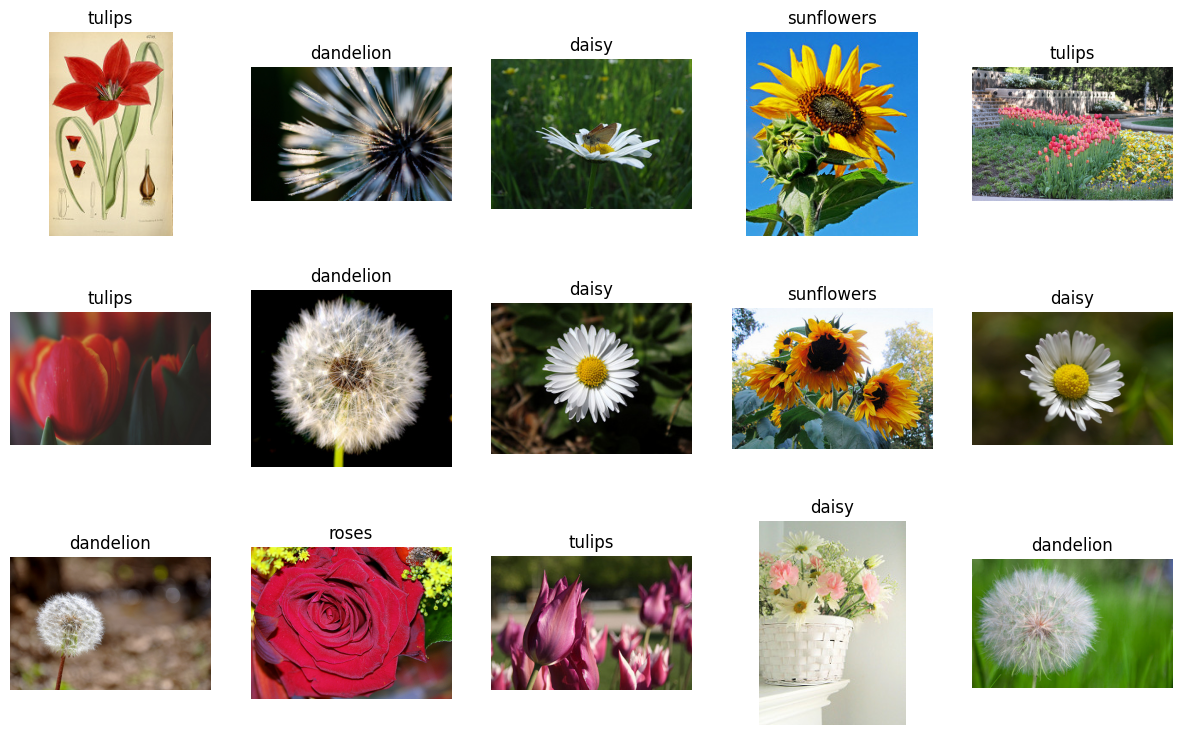

In [5]:
#@title Show some labeled images
def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, flower_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(flower_class)

NUM_IMAGES = 15 #@param {type: 'integer'}
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

## 构建模型

我们将加载 [TF-Hub](https://tensorflow.org/hub) 图像特征向量模块，在它上面堆叠一个线性分类器，并添加训练和评估运算。以下单元将构建一个描述模型及其训练的 TF 计算图，但不会运行训练（这是下一个步骤）。

In [6]:
LEARNING_RATE = 0.01

tf.reset_default_graph()

# Load a pre-trained TF-Hub module for extracting features from images. We've
# chosen this particular module for speed, but many other choices are available.
image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2')

# Preprocessing images into tensors with size expected by the image module.
encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)


def decode_and_resize_image(encoded):
  decoded = tf.image.decode_jpeg(encoded, channels=3)
  decoded = tf.image.convert_image_dtype(decoded, tf.float32)
  return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# The image module can be applied as a function to extract feature vectors for a
# batch of images.
features = image_module(batch_images)


def create_model(features):
  """Build a model for classification from extracted features."""
  # Currently, the model is just a single linear layer. You can try to add
  # another layer, but be careful... two linear layers (when activation=None)
  # are equivalent to a single linear layer. You can create a nonlinear layer
  # like this:
  # layer = tf.layers.dense(inputs=..., units=..., activation=tf.nn.relu)
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)
  return layer


# For each class (kind of flower), the model outputs some real number as a score
# how much the input resembles this class. This vector of numbers is often
# called the "logits".
logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Mathematically, a good way to measure how much the predicted probabilities
# diverge from the truth is the "cross-entropy" between the two probability
# distributions. For numerical stability, this is best done directly from the
# logits, not the probabilities extracted from them.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# Let's add an optimizer so we can train the network.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

# The "softmax" function transforms the logits vector into a vector of
# probabilities: non-negative numbers that sum up to one, and the i-th number
# says how likely the input comes from class i.
probabilities = tf.nn.softmax(logits)

# We choose the highest one as the predicted class.
prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))

# The accuracy will allow us to eval on our test set. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tmpfs/tmp/ipykernel_17023/2879154528.py:34: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)


## 训练网络

现在，模型已经构建，我们来对它进行训练，并查看它在测试集上的性能。

In [7]:
# How long will we train the network (number of batches).
NUM_TRAIN_STEPS = 100 #@param {type: 'integer'}
# How many training examples we use in each step.
TRAIN_BATCH_SIZE = 10 #@param {type: 'integer'}
# How often to evaluate the model performance.
EVAL_EVERY = 10 #@param {type: 'integer'}

def get_batch(batch_size=None, test=False):
  """Get a random batch of examples."""
  examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
  batch_examples = random.sample(examples, batch_size) if batch_size else examples
  return batch_examples

def get_images_and_labels(batch_examples):
  images = [get_encoded_image(e) for e in batch_examples]
  one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
  return images, one_hot_labels

def get_label_one_hot(example):
  """Get the one hot encoding vector for the example."""
  one_hot_vector = np.zeros(NUM_CLASSES)
  np.put(one_hot_vector, get_label(example), 1)
  return one_hot_vector

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(NUM_TRAIN_STEPS):
    # Get a random batch of training examples.
    train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
    batch_images, batch_labels = get_images_and_labels(train_batch)
    # Run the train_op to train the model.
    train_loss, _, train_accuracy = sess.run(
        [cross_entropy_mean, train_op, accuracy],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
    is_final_step = (i == (NUM_TRAIN_STEPS - 1))
    if i % EVAL_EVERY == 0 or is_final_step:
      # Get a batch of test examples.
      test_batch = get_batch(batch_size=None, test=True)
      batch_images, batch_labels = get_images_and_labels(test_batch)
      # Evaluate how well our model performs on the test set.
      test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
        [cross_entropy_mean, accuracy, prediction, correct_prediction],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
      print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 26.36%


Test accuracy at step 10: 50.14%


Test accuracy at step 20: 65.62%


Test accuracy at step 30: 68.34%


Test accuracy at step 40: 73.78%


Test accuracy at step 50: 77.17%


Test accuracy at step 60: 77.31%


Test accuracy at step 70: 77.31%


Test accuracy at step 80: 79.21%


Test accuracy at step 90: 80.71%


Test accuracy at step 99: 79.35%


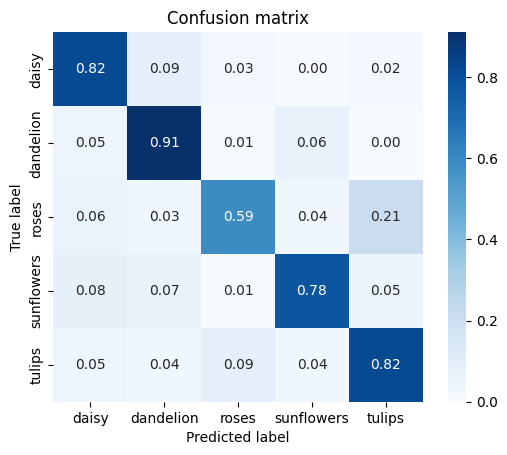

In [8]:
def show_confusion_matrix(test_labels, predictions):
  """Compute confusion matrix and normalize."""
  confusion = sk_metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), predictions)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = list(CLASSES.values())
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)

## 错误的预测

让我们仔细看看模型预测出错的测试样本。

- 测试集中是否有标签错误的样本？
- 测试集中是否有不良数据（即图像实际上不是花卉图片）？
- 是否存在能够让您理解模型出错原因的图像？

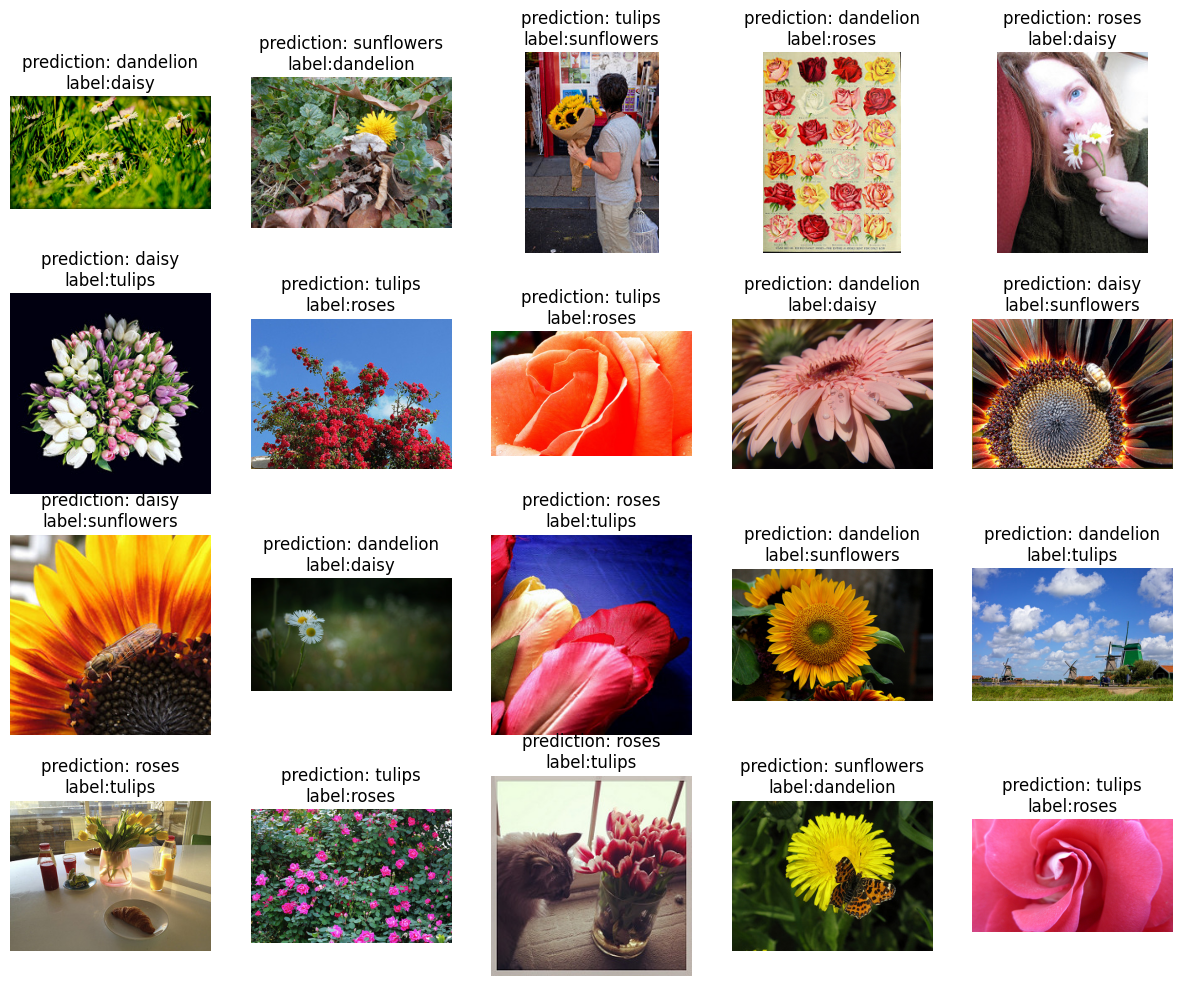

In [9]:
incorrect = [
    (example, CLASSES[prediction])
    for example, prediction, is_correct in zip(test_batch, test_prediction, correct_predicate)
    if not is_correct
]
display_images(
  [(get_image(example), "prediction: {0}\nlabel:{1}".format(incorrect_prediction, get_class(example)))
   for (example, incorrect_prediction) in incorrect[:20]])

## 练习：改进模型！

我们已经训练了一个基础模型，现在我们来尝试对它进行改进，以实现更好的准确率。（请记住，更改后需要重新运行代码单元。）

### 练习 1：尝试不同的图像模型。

使用 TF-Hub，尝试几种不同的图像模型非常简单。只需将 `hub.Module()` 调用中的 `"https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2"` 句柄替换为其他模块的句柄，然后重新运行所有代码即可。您可以在 [tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector) 上查看所有可用的图像模块。

其他 [MobileNet V2 模块](https://tfhub.dev/s?module-type=image-feature-vector&network-architecture=mobilenet-v2)可能会是不错的选择。许多模块（包括 MobileNet 模块）都在 [ImageNet 数据集上](https://tensorflow.google.cn/datasets/catalog/imagenet2012)进行了训练，该数据集包含超过一百万个图像和 1000 个类。选择网络架构需要在速度和分类准确率之间进行权衡：像 MobileNet 或 NASNet Mobile 这样的模型既快又小，而更传统的架构（如 Inception 和 ResNet）则为准确率而设计。

对于较大的 Inception V3 架构，您还可以探索在更接近您的任务的域上进行预训练的好处：它还可以作为[已在 iNaturalist 动植物数据集上训练的模块](https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/1)进行提供。

### 练习 2：添加隐藏层。

在提取的图像特征和线性分类器之间堆叠一个隐藏层（在上述 `create_model()` 函数中）。例如，要用 100 个节点创建一个非线性隐藏层，请使用 [tf.layers.dense](https://tensorflow.google.cn/api_docs/python/tf/compat/v1/layers/dense)（将单元设置为 100，并将激活设置为 `tf.nn.relu`）。更改隐藏层的大小是否会影响测试准确率？添加第二个隐藏层是否会提高准确率？

### 练习 3：更改超参数。

增加*训练步骤的数量*是否能够提高最终的准确率？是否可以通过*更改学习率*使模型更快收敛？训练*批次大小*是否会影响模型的性能？

### 练习 4：尝试不同的优化器。

用更复杂的[优化器](https://tensorflow.google.cn/api_docs/python/tf/compat/v1/train/AdagradOptimizer)（例如 [AdagradOptimizer](http://ruder.io/optimizing-gradient-descent/)）替换基本的 GradientDescentOptimizer。这是否会对您的模型训练产生影响？如果您想详细了解不同优化算法的优势，请阅读<a>这篇博文</a>。

## 了解更多信息

如果您对本教程的更高级版本有兴趣，请查看 [TensorFlow 图像重新训练教程](https://tensorflow.google.cn/hub/tutorials/image_retraining)，该教程将引导您使用 TensorBoard 对训练进行可视化，介绍高级技术（如通过扭曲图像进行数据集扩充），以及将花卉数据集替换为您自己的数据集供图像分类器进行学习。

您可以在 [tensorflow.org](http://tensorflow.org) 上详细了解 TensorFlow，并在 [tensorflow.org/hub](https://tensorflow.google.cn/hub/) 上查看 TF-Hub API 文档。还可以在 [tfhub.dev](http://tfhub.dev) 上找到可用的 TensorFlow Hub 模块，包括更多图像特征向量模块和文本嵌入向量模块。

另外，请查看[机器学习速成课程](https://developers.google.com/machine-learning/crash-course/)，这是 Google 提供的针对机器学习的快节奏实用介绍。